**Nama : Geraldus Jeremy Chandra**

**NIM : 2702368236**

**TUJUAN**



Pada soal pertama ini, tujuannya adalah untuk membandingkan model mana yang paling bagus untuk prediksi kualitas udara suatu wilayah (AT) dengan pendekatan LSTM menggunakan MAE, MSE, dan R2 square sebagai acuan. Ada 3 model yang akan dibandingkan, yaitu model baseline, model baseline yang dimodify manual, dan model baseline yang dimodify dengan hyperparameter tuning.

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


**IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**EDA & PREPROCESSING**

In [ ]:
df = pd.read_csv("AP003.csv")

In [ ]:
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

In [ ]:
df['From Date'] = pd.to_datetime(df['From Date'])
df.set_index('From Date', inplace=True)

In [ ]:
df.drop('To Date', axis=1, inplace=True)

mengubah from date menjadi date time dan menjadi index, lalu kolom to date di hapus. ini akan menyisakan 20 kolum tersisa. Data sekarang mempunyai index berbasi waktu untuk analisis time series.


In [ ]:
cleaned_columns = []
for col in df.columns:

    cleaned_col = col.lower().replace('(','').replace(')','').replace('.','').replace('/','').replace(' ','_')
    cleaned_columns.append(cleaned_col)
df.columns = cleaned_columns

Mengubah ke huruf kecil, mengganti spasi dan karakter khusus dengan '_' untuk memudahkan proses pemanggilan tanpa resiko adanya error

In [ ]:
print("Persentase data hilang sebelum imputasi:")
print((df.isnull().sum() / len(df) * 100).sort_values(ascending=False))

df.interpolate(method='linear', inplace=True)

print("\nJumlah data hilang setelah interpolasi:")
print(df.isnull().sum().sum())

if df.isnull().sum().sum() > 0:
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)

Persentase data hilang sebelum imputasi:
so2_ugm3         13.484127
bp_mmhg          13.333333
pm25_ugm3        11.327381
wd_degree        11.289683
pm10_ugm3        10.678571
ozone_ugm3       10.101190
no2_ugm3          9.315476
nh3_ugm3          9.214286
no_ugm3           8.230159
temp_degree_c     8.065476
at_degree_c       7.996032
rh_%              7.698413
ws_ms             7.694444
xylene_ugm3       7.424603
toluene_ugm3      7.384921
benzene_ugm3      7.384921
co_mgm3           6.759921
nox_ppb           6.666667
vws_ms            6.660714
sr_wmt2           6.656746
rf_mm             6.452381
dtype: float64

Jumlah data hilang setelah interpolasi:
4


/tmp/ipython-input-11-1251195867.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-11-1251195867.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Data tidak ada yang didrop karena krusial untuk timeseries sehingga saya melakukan imputasi. imputasi dilakukan tidak dengan mean median namun dengan function interpolate, metode yang cocok untuk data yang perubahannya gradual dari waktu ke waktu. Metode ini menghitung satu nilai statistik (rata-rata atau nilai tengah) dari seluruh kolom yang memiliki data. Kemudian, setiap sel kosong (NaN) di kolom tersebut diisi dengan nilai tunggal ini. nilai valid terakhir sebelum hilang dan pertama setelah hilang dijadikan acuan untuk nanti digambar garis lurus dan diisi nilai sepanjang garis itu.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50400 entries, 2017-07-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pm25_ugm3      50400 non-null  float64
 1   pm10_ugm3      50400 non-null  float64
 2   no_ugm3        50400 non-null  float64
 3   no2_ugm3       50400 non-null  float64
 4   nox_ppb        50400 non-null  float64
 5   nh3_ugm3       50400 non-null  float64
 6   so2_ugm3       50400 non-null  float64
 7   co_mgm3        50400 non-null  float64
 8   ozone_ugm3     50400 non-null  float64
 9   benzene_ugm3   50400 non-null  float64
 10  toluene_ugm3   50400 non-null  float64
 11  temp_degree_c  50400 non-null  float64
 12  rh_%           50400 non-null  float64
 13  ws_ms          50400 non-null  float64
 14  wd_degree      50400 non-null  float64
 15  sr_wmt2        50400 non-null  float64
 16  bp_mmhg        50400 non-null  float64
 17  vws_ms         

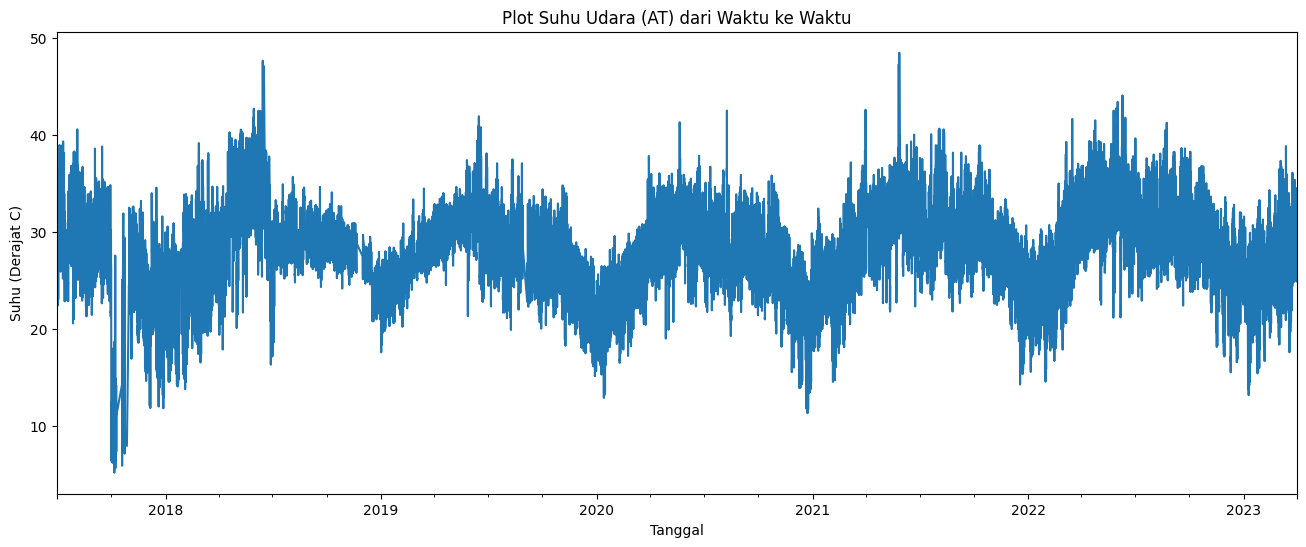

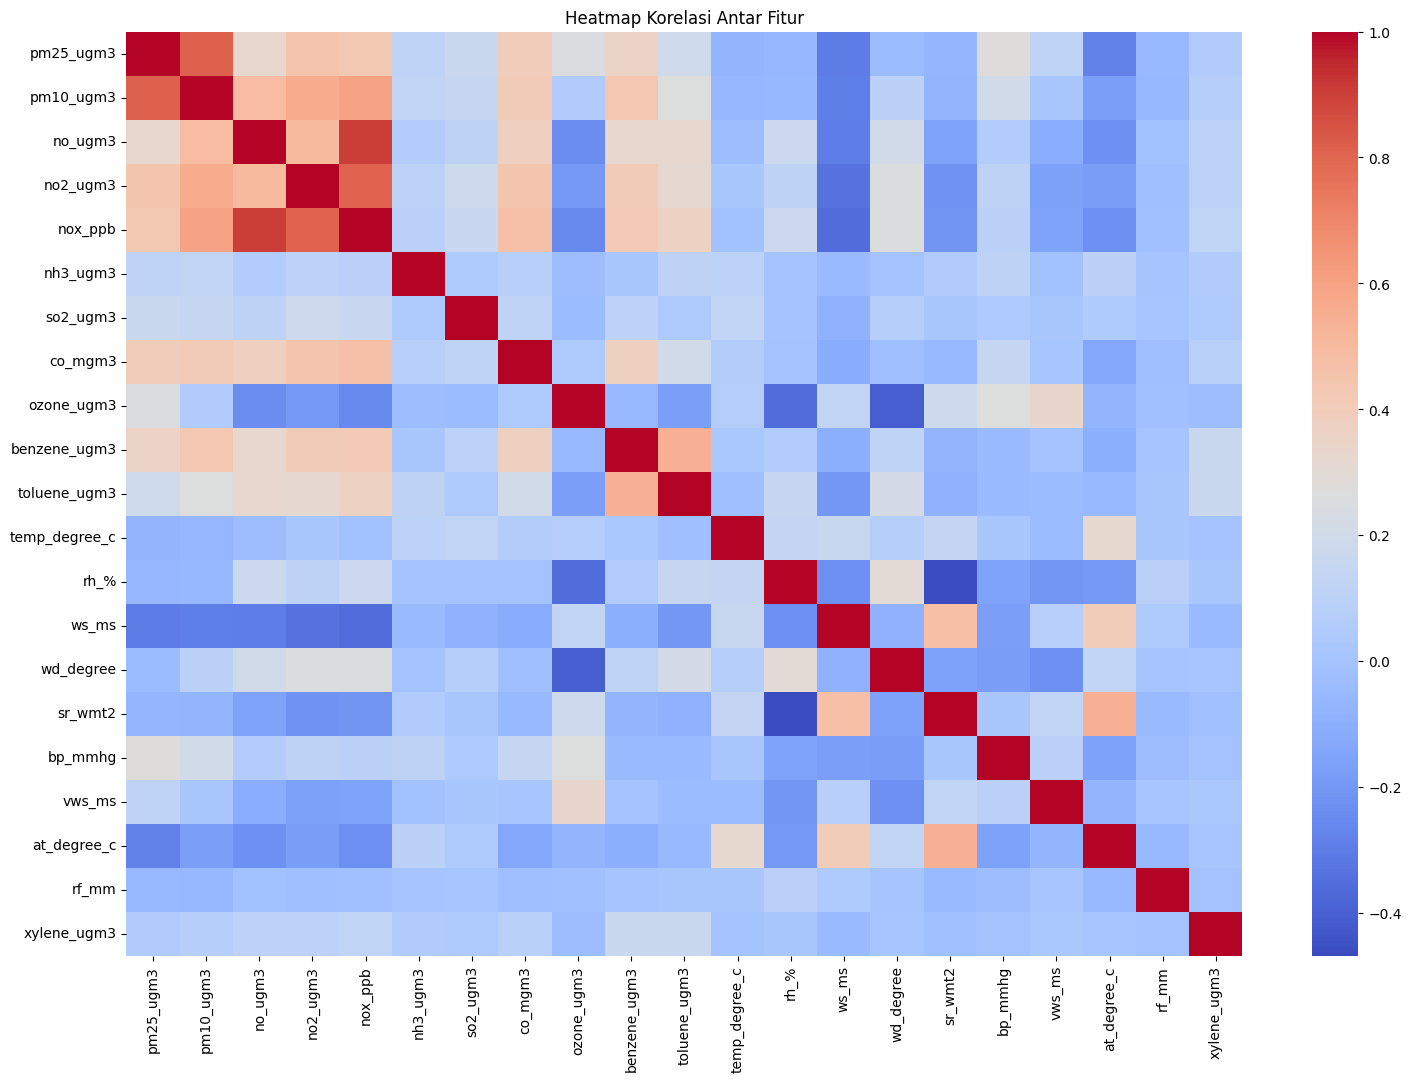

In [ ]:
plt.figure(figsize=(16, 6))
df['at_degree_c'].plot()
plt.title('Plot Suhu Udara (AT) dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (Derajat C)')
plt.show()

plt.figure(figsize=(18, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

plot pertama menjukan pergerakan suhu yang cukup jelas dari segi polanya, dimana di sekitar awal tahun dan akhir tahun secara konsisten mencapai titik terendahnya dan mencapai titik tertingginya di pertengahan tahun. tidak ada trend jangka panjang seperti kenaikan atau penurunan setiap tahunnya.

untuk plot heatmap pertama untuk korelasinya dengan target kita at, korelasi positif bisa kita lihat dengan sr(solar radiation) yang mana masuk akal karena semakin tinggi suhunya semakin tinggi juga radiasi solar. ada juga korelasi negatif yang cukup kuat dengan rh (kelembapan relatif) yang cenderung di suhu yang lebih rendah.

In [ ]:
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

print("Ukuran set Training:", train_df.shape)
print("Ukuran set Validasi:", val_df.shape)
print("Ukuran set Testing:", test_df.shape)

Ukuran set Training: (40320, 21)
Ukuran set Validasi: (5040, 21)
Ukuran set Testing: (5040, 21)


bagi data training, testing, dan validation menjadi ratio 80 :10:10. sesuai ketentuan soal.

In [ ]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df)

val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, index=train_df.index, columns=df.columns)
val_scaled_df = pd.DataFrame(val_scaled, index=val_df.index, columns=df.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test_df.index, columns=df.columns)

scaling dengan minmaxscaler mengubah semua nilai menjadi dalma rentang 0 sampai 1.

In [ ]:
def create_sequences(data_array, feature_columns, history_size, target_col_name, target_horizon):
    X, y = [], []
    target_col_index = list(feature_columns).index(target_col_name)

    for i in range(len(data_array) - history_size - target_horizon + 1):
        input_window = data_array[i:(i + history_size), :]
        X.append(input_window)

        target_value = data_array[i + history_size + target_horizon - 1, target_col_index]
        y.append(target_value)

    return np.array(X), np.array(y)

HISTORY_SIZE = 5
TARGET_HORIZON = 1
TARGET_COLUMN_NAME = 'at_degree_c'

X_train, y_train = create_sequences(train_scaled_df.values, train_scaled_df.columns, HISTORY_SIZE, TARGET_COLUMN_NAME, TARGET_HORIZON)
X_val, y_val = create_sequences(val_scaled_df.values, val_scaled_df.columns, HISTORY_SIZE, TARGET_COLUMN_NAME, TARGET_HORIZON)
X_test, y_test = create_sequences(test_scaled_df.values, test_scaled_df.columns, HISTORY_SIZE, TARGET_COLUMN_NAME, TARGET_HORIZON)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40315, 5, 21)
y_train shape: (40315,)
X_val shape: (5035, 5, 21)
y_val shape: (5035,)
X_test shape: (5035, 5, 21)
y_test shape: (5035,)


membuat function untuk mengubah data time series menjadi format supervised learning, dimana input x dari 5 jam terakhir dan output y dari AT dalam 1 jam ke depan.

**MODELLING**

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

input_layer_baseline = Input(shape=input_shape)
lstm_layer_baseline = LSTM(units=10, name='LSTM_Baseline')(input_layer_baseline)
output_layer_baseline = Dense(units=1, activation='linear', name='Output_Regressor')(lstm_layer_baseline)

model_baseline = Model(inputs=input_layer_baseline, outputs=output_layer_baseline)
model_baseline.compile(optimizer=Adam(learning_rate=0.001),
                       loss='mean_squared_error',
                       metrics=['mean_absolute_error'])
model_baseline.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_baseline = model_baseline.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Baseline (LSTM)            │ (None, 10)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Regressor (Dense)        │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,291 (5.04 KB)

 Trainable params: 1,291 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0606 - val_loss: 9.9407e-04 - val_mean_absolute_error: 0.0223
Epoch 2/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.4758e-04 - mean_absolute_error: 0.0204 - val_loss: 7.4414e-04 - val_mean_absolute_error: 0.0195
Epoch 3/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 6.2770e-04 - mean_absolute_error: 0.0170 - val_loss: 7.6414e-04 - val_mean_absolute_error: 0.0196
Epoch 4/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.0901e-04 - mean_absolute_error: 0.0152 - val_loss: 5.2638e-04 - val_mean_absolute_error: 0.0156
Epoch 5/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.7523e-04 - mean_absolute_error: 0.0142 - val_loss: 5.5000e-04 - val_mean_absolute_error: 0.0170
Epoch 6/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.3051e-04 - mean_absolute_error: 0.0136 - val_loss: 4.9426e-04 - val_mean_absolute_error: 0.0150
Epoch 7/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━

ini adalah model baseline satu layer LSTM dengan 10 unit, menggunakan adam sebagai optimizer dan MSE untuk loss function, early stopping digunakan untuk berhenti jika validation atanya tidak membaik setelah 5 epoch, menghemat waktu dan mencegah overfit

In [ ]:
input_layer_manual = Input(shape=input_shape)
lstm1_manual = LSTM(units=50, return_sequences=True, name='LSTM_1_Manual')(input_layer_manual)
dropout_manual = Dropout(0.2, name='Dropout_Manual')(lstm1_manual)
lstm2_manual = LSTM(units=25, name='LSTM_2_Manual')(dropout_manual)
output_layer_manual = Dense(units=1, activation='linear', name='Output_Regressor')(lstm2_manual)

model_manual = Model(inputs=input_layer_manual, outputs=output_layer_manual)

model_manual.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mean_squared_error',
                     metrics=['mean_absolute_error'])

model_manual.summary()

history_manual = model_manual.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1_Manual (LSTM)            │ (None, 5, 50)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Manual (Dropout)        │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2_Manual (LSTM)            │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Regressor (Dense)        │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,026 (86.04 KB)

 Trainable params: 22,026 (86.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0111 - mean_absolute_error: 0.0659 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307
Epoch 2/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 7.2234e-04 - val_mean_absolute_error: 0.0190
Epoch 3/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8.7159e-04 - mean_absolute_error: 0.0211 - val_loss: 5.9333e-04 - val_mean_absolute_error: 0.0183
Epoch 4/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.8298e-04 - mean_absolute_error: 0.0188 - val_loss: 5.4430e-04 - val_mean_absolute_error: 0.0162
Epoch 5/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.6770e-04 - mean_absolute_error: 0.0170 - val_loss: 5.3671e-04 - val_mean_absolute_error: 0.0164
Epoch 6/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 5.3523e-04 - mean_absolute_error: 0.0160 - val_loss: 4.8237e-04 - val_mean_absolute_error: 0.0150
Epoch 7/50
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 7

model kedua yang dimodifikasi manual memiliki perbedaan di regularisasinya yang ditambahi dropout. return sequences = true memastikan outputnya ada di setiap step dan dropout secara acak menonaktifkan koneksi untuk mencegah ketergantungan pada fitur tertentu. koneksi di set 0.2 atau 20%.

In [ ]:
def build_model(hp):
    hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    input_layer = Input(shape=input_shape)
    lstm_layer = LSTM(units=hp_units)(input_layer)
    dropout_layer = Dropout(rate=hp_dropout)(lstm_layer)
    output_layer = Dense(1, activation='linear')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

selanjutnya untuk hyperparameter tuningnya pertama dibuat function untuk template untuk semua model yang akan dicoba oleh keras tuner, bertugas define arsitektur model dimana beberapa nilainya bisa diubah-ubah. hp.int untuk untuk bilangan bulat, float untuk float dan hp.choice untuk pilihan 0.1, 0.001 dan 0.0001

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='air_quality_lstm'
)


tuner.search_space_summary()


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 10, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


bagian ini untuk configure tuner untuk tujuan searchingnya. diset val loss sebagai metrik yang dicari. max trials berarti berapa lama dilakukan trialsnya, 10 percobaan diset dan setlah itu tunernya berhetni. directory dan project name untuk menyimpan hasil percobaan.

In [ ]:
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

best_model_tuned = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f" - Units LSTM: {best_hyperparameters.get('units')}")
print(f" - Dropout Rate: {round(best_hyperparameters.get('dropout'),2)}")
print(f" - Learning Rate: {best_hyperparameters.get('learning_rate')}")

print("\nArsitektur Model Terbaik Hasil Tuning:")
best_model_tuned.summary()

Trial 10 Complete [00h 02m 53s]
val_loss: 0.0006159143522381783

Best val_loss So Far: 0.00039165563066489995
Total elapsed time: 00h 27m 17s
 - Units LSTM: 30
 - Dropout Rate: 0.1
 - Learning Rate: 0.001

Arsitektur Model Terbaik Hasil Tuning:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,271 (24.50 KB)

 Trainable params: 6,271 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

trakhir tuner search untuk start tuning dengan x train dan y train sebagai model percobaannya. epoch 20 dijalankan sebanyak trial yang sudah diset sebelomnya. total 200 epoch. xval dan yval untuk indikator tuner kita memutuskan performa model mana yang lebih baik. Kita tidak perlu lagi menjalankan epoch tambahan setelah proses hyperparameter tuning selesai karena proses tuner.search() itu sendiri bukan hanya mencari, tetapi juga sekaligus melatih.

**EVALUATION**

In [ ]:
models = {
    "Baseline": model_baseline,
    "Modifikasi Manual": model_manual,
    "Hasil Tuning": best_model_tuned
}

evaluation_results = []

dummy_y_test = np.zeros((len(y_test), X_train.shape[2]))
at_column_index = list(train_scaled_df.columns).index('at_degree_c')
dummy_y_test[:, at_column_index] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_y_test)[:, at_column_index]

set list untuk tiap model dan dictionary untul hasil eval. lalu array dibuat untuk mengakomodasi scaler yang dilatih pada 21 fitur dalam varibale dummy_y_test. at_column_index untuk mencari index kolum target 'at_degree_c'. y_tes lalu dimasukkan ke kolom yang benar. terakhir, inverse transform dilakukan untuk y test untuk mengembalikan range 0-1 ke nilai sebenarnya untuk evaluation.

In [ ]:
for model_name, model in models.items():
    print(f"--- Mengevaluasi Model: {model_name} ---")

    predictions_scaled = model.predict(X_test)

    dummy_predictions = np.zeros((len(predictions_scaled), X_train.shape[2]))
    dummy_predictions[:, at_column_index] = predictions_scaled.flatten()
    predictions_original = scaler.inverse_transform(dummy_predictions)[:, at_column_index]

    mae = mean_absolute_error(y_test_original, predictions_original)
    mse = mean_squared_error(y_test_original, predictions_original)
    r2 = r2_score(y_test_original, predictions_original)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}\n")

    evaluation_results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "R2 Score": r2
    })

results_df = pd.DataFrame(evaluation_results)
print("--- Ringkasan Hasil Evaluasi ---")
print(results_df.to_string())

--- Mengevaluasi Model: Baseline ---
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.5875
MSE: 0.6960
R2 Score: 0.9576

--- Mengevaluasi Model: Modifikasi Manual ---
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.5988
MSE: 0.6982
R2 Score: 0.9575

--- Mengevaluasi Model: Hasil Tuning ---
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.5530
MSE: 0.6616
R2 Score: 0.9597

--- Ringkasan Hasil Evaluasi ---
               Model       MAE       MSE  R2 Score
0           Baseline  0.587495  0.695950  0.957601
1  Modifikasi Manual  0.598827  0.698205  0.957463
2       Hasil Tuning  0.553020  0.661618  0.959692


dibuat looping untuk mengevalusi setiap modelnya. pertama dibuat prediksi untuk x_test. lalu inverse transform hasil predictionnya. dan terakhir metrik evaluation dihitung dan diprint.

**PEMBAHASAN ANALISIS**

membandingkan ketiga model yang sudah kita buat (baseline model, modifikasi baseline, dan hyperparameter tuning) kita bisa melihat bahwa hasil tuning memiliki nilai yang paling baik, dengan mae dan mse paling kecil di angka 0.553020 dan 0.661618 dan r2 score paling tinggi di angka 0.959692 yang dapat dikategorikan cukup baik. hasil yang terlihat mungkin tidak memiliki hasil yang berbeda sangat jauh. namun, model baseline yang terlalu sederhana mungkin menyebabkan underfiting. Sementara hasil tuning secara sistematis menemukan konfigurasi yang paling optimal untuk data ini yaitu LSTM yang lebih banyak dan dropout yang lebih rendah. Hasil mungkin bisa diimprove jika search tuner yang dibuat memiliki arsitektur yang lebih bervariasi seperti layer yang lebih, atau jenis layer lain seperti GRU.

**KESIMPULAN**

Kesimpulannya hasil tuning menjadi nilai yang lebih baik karena proses hyperparameter menemukan komposisi yang paling bagus yaitu units yang kita set 60. hal ini memberikan kapasitas memori yang memungkinkan layer lstm kita belajar lebih baik, model kita dapat menangkap pola-pola yang lebih detail dan kompleks dibandingkan dengan model baseline. Lalu regularisation dropout 0.1 menjadi pilihan yang lebih tepat. walaupun dihambat secara ringan untuk kapasitas yang lebih besar 60, regularisasi ini cukup untuk mencegah model menghafal datanya atau overfitting. secara singkat, kapasitas yang lebih besar dengan regularisasi yang lebih terkontrol dan tidak berlebihan menjadi model yang optimal.

**BONUS QUESTION**

Ya, problem ini dapat menggunakan multivariate timeseries. suatu dataset dapat dikategorikan dapat dikatakan multivariate ketika memiliki lebih dari satu variabel waktu yang saling berhubungan dan **memprediksi lebih dari satu target**. berbeda dengan multivariable yang saya kerjakan sekarang karena hanya **memprediksi satu target.**  Untuk problem ini, terlihat ada banyak variable yang saling berkorelasi satu sama lain untuk menjadi indikator dalam memprediksi target. sebagai contoh PM2.5, suhu(AT), kelembapan(RH) dari total 20 fitur merupakan variabel yang dicatat secara urutan waktu yang dapat digunakan untuk memprediksi sesuatu. Hubungan variabel yang kuat juga terlihat sebagai contoh radiasi matahari dan kelembapan yang mempengaruhi suhu udara. Tujuan baru bisa dilakukan untuk memprediksi ketiga target tersebut sekaligus (AT, RH, PM2.5). Tentunya sequences dan arsitekturnya harus diseuaikan dan evaluasi metriksnya untuk seluruh targetnya.